In [1]:
from neo4j import GraphDatabase

user_id = 1110008753489760261
tweet_id = 1109874238398320640
politic_usa_id = 14792049

uri = 'bolt://localhost:7687'
driver = GraphDatabase.driver(uri)

In [2]:
def retrieve_all_tweet_stories():
    message = """MATCH p=(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(start:Tweet {type: 'TWEET'})
                 WHERE NOT (start)-[:REPLIED_TO|RETWEETED_FROM]->() AND NOT ()-[:REPLIED_TO|RETWEETED_FROM]->(end)
                 WITH *, relationships(p) AS r
                 RETURN end.created_at, start.created_at, r"""
    records = driver.session().run(message).data()
    return records

In [3]:
def retrieve_tweet_story(tweet_id):
    message = """MATCH p=(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(start:Tweet {type: 'TWEET'})
                 WHERE NOT (start)-[:REPLIED_TO|RETWEETED_FROM]->() AND NOT ()-[:REPLIED_TO|RETWEETED_FROM]->(end)
                 AND start.id = {id}
                 WITH *, relationships(p) AS r
                 RETURN end.created_at, start.created_at, r"""
    records = driver.session().run(message, id=tweet_id).data()
    return records

In [4]:
def retrieve_users_who_interacted_at_a_story(tweet_id):
    message = """MATCH u=(user:User)-[:TWEETED|POSTED_REPLY|POSTED_RETWEET]->(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(start:Tweet)<-[:TWEETED]-(storyStarter:User)
                 WHERE start.id = {id} AND (end.type = 'RETWEET' OR end.type = 'REPLY') AND start.type = 'TWEET'
                 RETURN user, storyStarter"""
    records = driver.session().run(message, id=tweet_id).data()
    return records

In [5]:
def retrieve_stories_where_user_is_involved(user_id):
    message = """MATCH u=(user:User)-[:TWEETED|POSTED_REPLY|POSTED_RETWEET]->(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(start:Tweet)<-[:TWEETED]-(storyStarter:User)
                 WHERE user.id = {id} or storyStarter.id = {id} AND (end.type = 'RETWEET' OR end.type = 'REPLY') AND start.type = 'TWEET'
                 WITH *, relationships(u) as re
                 RETURN end, re, start, user, storyStarter"""
    records = driver.session().run(message, id=user_id).data()
    return records

In [6]:
def retrieve_tweet_chain_ordered_by_time(tweet_id):
    # not needed, tweet chains are created in order in the first place
    print()

In [7]:
def retrieve_stories_made_by_user(user_id):
    message = """MATCH u=(user:User)-[:TWEETED]->(tweet:Tweet)
                 WHERE user.id = {id}
                 MATCH p=(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(tweet:Tweet)
                 WHERE end.type = 'RETWEET' OR end.type = 'REPLY' AND tweet.type = 'TWEET'
                 RETURN u"""
    records = driver.session().run(message, id=user_id).value()
    return records

In [8]:
def retrieve_time_spread_of_tweet_story(tweet_id):
    records = retrieve_tweet_story(tweet_id)[0]
    start_time = records['start.created_at']
    end_time = records['end.created_at']
    message = "Original tweet was posted on %s. \nLast available reaction was posted on %s." % (start_time, end_time)
    
    return message

In [9]:
def trial_and_error(tweet_id):
    message = """MATCH u=(user:User)-[r:POSTED_REPLY|POSTED_RETWEET]->(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(start:Tweet {id: {id}, type: 'TWEET'})<-[:TWEETED]-(storyStarter:User)
                 WHERE end.type = 'RETWEET' OR end.type = 'REPLY'
                 RETURN user, end.created_at as timestamp"""
    records = driver.session().run(message, id=tweet_id).data()
    return records

In [10]:
def get_users_from_tweet_story(tweet_id):
    message = """MATCH u=(user:User)-[r:POSTED_REPLY|POSTED_RETWEET]->(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(start:Tweet {id: {id}, type: 'TWEET'})<-[:TWEETED]-(storyStarter:User)
                 WHERE end.type = 'RETWEET' OR end.type = 'REPLY'
                 RETURN user.screen_name as user, end.created_at as timestamp, storyStarter.screen_name as starter, start.created_at as origin"""
    records = driver.session().run(message, id=tweet_id).data()
    return records

In [11]:
def check_if_source_follows_target(source, target):
    message = "MATCH u=({screen_name: {source}})-[:FOLLOWS]->({screen_name: {target}}) RETURN u"
    records = driver.session().run(message, source=source, target=target).values()
    return records

In [12]:
if check_if_source_follows_target('erinbaby', 'politicususa'):
    print('hello')
print(check_if_source_follows_target('erinbaby', 'politicususa'))

hello
[[<Path start=<Node id=77671 labels={'User'} properties={'followers': 354, 'id': 1109874352479047680, 'screen_name': 'erinbaby', 'friends': 457}> end=<Node id=68621 labels={'User'} properties={'followers': 68790, 'id': 14792049, 'screen_name': 'politicususa', 'friends': 4015}> size=1>]]


In [14]:
# print(retrieve_tweet_story(1109874238398320640))
# print(retrieve_users_who_interacted_at_a_story(1109874238398320640))
# for value in retrieve_stories_made_by_user(politic_usa_id):
#     print(value)
#     print("HELLO DARKNESS WORLD")
#     print("\n")

# print(retrieve_time_spread_of_tweet_story(tweet_id))

# print(retrieve_users_who_interacted_at_a_story(tweet_id))
# print(trial_and_error(tweet_id))

listOfIds = [1109973027255664643,
    1109953086108381185,
    1109973771371376640,
    1109983287240474624,
    1109850542950531073,
    1109790735367200773,
    1109738825738117120,
    1109922557959000064,
    1109957082722250753,
    1109940939555065857,
    1110001365068251137,
    1109791857775661056,
    1109874238398320640,
    1109884141581918208]
# for tw_id in listOfIds:
#     print('hello')
results = get_users_from_tweet_story(tweet_id)
obj = {
        'user': results[0]['starter'],
        'timestamp': results[0]['origin'],
        'followers': []
    }
listOfUsers = [obj]
for record in results:
    obj = {
        'user': record['user'],
        'timestamp': record['timestamp'],
        'followers': []
    }
    listOfUsers.append(obj)

# print(listOfUsers)
for user in listOfUsers:
#     followers = []
    for i in range(1,len(listOfUsers) - 1):
        if user['user'] != listOfUsers[i]['user'] and check_if_source_follows_target(listOfUsers[i]['user'], user['user']):
            if listOfUsers[i]['user'] not in user['followers']:
                user['followers'].append(listOfUsers[i]['user'])
#     record['followers'] = followers
for record in listOfUsers:
    print(record)

{'user': 'politicususa', 'timestamp': 'Sun Mar 24 17:46:53 EET 2019', 'followers': ['erinbaby', 'MiamiNice57', 'silverthornn264', 'MarianMme16513', 'WhobbaBobba', 'Hattonsu', 'vinkoview', 'Mr_Scorpio', 'Bgolden53', 'MSMABAILEY', 'AwakenWholeness', 'maxthecat2000', 'MaryC_mlc4123', 'laleumen', 'syringa11', 'PolitiSmoose672', 'wininmad', 'evaleegifford11', 'genezog7', '7dnetwork', 'princessearl1st', 'LvnCali', 'mcp_pol', 'santo_aol', 'RBRB1516', 'maggievoelker', 'DianaSc99717236', 'Planelady1', 'StockScout1', 'FrenchieCat', 'wil91116385', 'gaelbill', 'chatta_girl', 'JohnnyHeldt', 'PolitJunkieM', 'cornerboy102000', 'purr10', 'barbara_kobrin', 'gramophoneman', 'Longley321']}
{'user': 'erinbaby', 'timestamp': 'Sun Mar 24 17:47:20 EET 2019', 'followers': []}
{'user': 'MiamiNice57', 'timestamp': 'Sun Mar 24 17:47:25 EET 2019', 'followers': ['sean_prevost']}
{'user': 'silverthornn264', 'timestamp': 'Sun Mar 24 17:48:18 EET 2019', 'followers': []}
{'user': 'MarianMme16513', 'timestamp': 'Sun Ma

In [83]:
import networkx as nx
import matplotlib.pyplot as plt

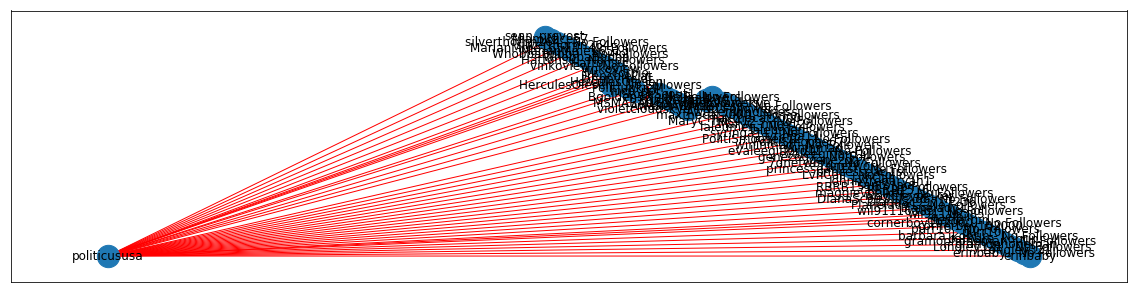

<Figure size 2160x1440 with 0 Axes>

[('politicususa', 'erinbaby'),
 ('politicususa', 'MiamiNice57'),
 ('politicususa', 'silverthornn264'),
 ('politicususa', 'MarianMme16513'),
 ('politicususa', 'WhobbaBobba'),
 ('politicususa', 'Hattonsu'),
 ('politicususa', 'vinkoview'),
 ('politicususa', 'Mr_Scorpio'),
 ('politicususa', 'Bgolden53'),
 ('politicususa', 'MSMABAILEY'),
 ('politicususa', 'AwakenWholeness'),
 ('politicususa', 'maxthecat2000'),
 ('politicususa', 'MaryC_mlc4123'),
 ('politicususa', 'laleumen'),
 ('politicususa', 'syringa11'),
 ('politicususa', 'PolitiSmoose672'),
 ('politicususa', 'wininmad'),
 ('politicususa', 'evaleegifford11'),
 ('politicususa', 'genezog7'),
 ('politicususa', '7dnetwork'),
 ('politicususa', 'princessearl1st'),
 ('politicususa', 'LvnCali'),
 ('politicususa', 'mcp_pol'),
 ('politicususa', 'santo_aol'),
 ('politicususa', 'RBRB1516'),
 ('politicususa', 'maggievoelker'),
 ('politicususa', 'DianaSc99717236'),
 ('politicususa', 'Planelady1'),
 ('politicususa', 'StockScout1'),
 ('politicususa', 'F

In [96]:
G = nx.DiGraph()
level = 0
for user in listOfUsers:
    level += 1
    G.add_node(user['user'], level=level)
    level += 1
    if not user['followers']:
        G.add_edge(user['user'], user['user'] + ' - No Followers')
    for follower in user['followers']:
        G.add_node(follower, level=level)
        G.add_edge(user['user'], follower, weight=counter * 2)
        
pos = nx.planar_layout(G)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 500)
nx.draw_networkx_edges(G, pos, edge_color='r', arrows=True)

plt.figure(figsize=(30,20))
plt.show()
list(G.edges)

In [38]:
# MATCH u=(user:User)-[r:TWEETED|POSTED_REPLY|POSTED_RETWEET]->(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(start:Tweet {id: 1109874238398320640, type: 'TWEET'})<-[:TWEETED]-(storyStarter:User)
# WHERE end.type = 'RETWEET' OR end.type = 'REPLY'
# WITH collect(user) as users, storyStarter, collect(end) as tweets, r, start
# UNWIND users AS user
# UNWIND tweets AS tweet
# MATCH pa=(someone:User)-[:POSTED_REPLY|POSTED_RETWEET]->(post:Tweet)-[:REPLIED_TO|RETWEETED_FROM]->(tweet)<-[:POSTED_REPLY|POSTED_RETWEET]-(user)
# WHERE post.created_at < tweet.created_at AND (exists((user)-[:FOLLOWS]->(someone)) OR exists((user)-[:FOLLOWS]->(storyStarter)))
# RETURN someone, user


In [ ]:
# MATCH u=(user:User)-[r:TWEETED|POSTED_REPLY|POSTED_RETWEET]->(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(start:Tweet {id: 1109874238398320640, type: 'TWEET'})<-[:TWEETED]-(storyStarter:User)
# WHERE end.type = 'RETWEET' OR end.type = 'REPLY'
# RETURN u


In [ ]:
# MATCH u=(user:User)-[r:TWEETED|POSTED_REPLY|POSTED_RETWEET]->(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(start:Tweet {id: 1109874238398320640, type: 'TWEET'})<-[:TWEETED]-(storyStarter:User)
# WHERE end.type = 'RETWEET' OR end.type = 'REPLY'
# WITH collect(user) as users, storyStarter, collect(end) as tweets, r
# RETURN users, storyStarter

In [ ]:
# MATCH u=(user:User)-[r:TWEETED|POSTED_REPLY|POSTED_RETWEET]->(end:Tweet)-[:REPLIED_TO|RETWEETED_FROM*]->(start:Tweet {id: 1109874238398320640, type: 'TWEET'})<-[:TWEETED]-(storyStarter:User)
# WHERE end.type = 'RETWEET' OR end.type = 'REPLY'
# WITH collect(user) as users, storyStarter, collect(end) as tweets, r, start
# RETURN tweets, start